In [1]:
import sys

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import pandas as pd

from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, HoverTool, PanTool, WheelZoomTool, LinearColorMapper, CategoricalColorMapper, BasicTicker, ColorBar
from bokeh.palettes import brewer 
from bokeh.plotting import figure, save
from bokeh.transform import transform

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load data from shape files
sys.path.append("../../src/utils")
from read_shapefiles import read_files

path_shapefiles, regions, provinces, territories, municipalities, crs = read_files.read_shapefile_data('../../src/utils/read_shapefiles/', 'shape_files_path.json')
df_mun_tus = read_files.read_shapefiles_in(True, path_shapefiles, municipalities, crs)
df_mun= read_files.read_shapefiles_in(False, path_shapefiles, municipalities, crs)
df_reg_tus = read_files.read_shapefiles_in(True, path_shapefiles, regions, crs)

In [3]:
# expand multipolygons
shp_expanded = df_mun_tus.set_index(['PRO_COM'])['geometry'].apply(pd.Series).stack().reset_index()
shp_expanded.rename(columns = {0: 'geometry'}, inplace = True)
df_mun_tus_exp = shp_expanded.merge(df_mun_tus.drop(columns = 'geometry'), on = 'PRO_COM', how = 'left')

shp_expanded = df_mun.set_index(['PRO_COM'])['geometry'].apply(pd.Series).stack().reset_index()
shp_expanded.rename(columns = {0: 'geometry'}, inplace = True)
df_mun_exp = shp_expanded.merge(df_mun.drop(columns = 'geometry'), on = 'PRO_COM', how = 'left')

In [4]:
# heatmap try
# sample trajectory files
path = '../../../../shared/cluster_results_Jul_Aug_10000_sample.csv'
df_clusters = pd.read_csv(path)
df_clusters = df_clusters.drop(columns=['Unnamed: 0', 'customer_nr'])

# geolocation preprocessing
r_path = "../../src/utils/geolocation"
sys.path.append(r_path)
import preprocessing 

preprocessing.str_to_list(df_clusters)
preprocessing.descriptive_sanity_check(df_clusters)


Number of individual trips: 10000

Mean number of visited municipalities = 75.08
Median number of visited municipalities = 33
Min number of visited municipalities = 2
Max number of visited municipalities = 1631


In [27]:
# create heatmaps gdfs

heatmap_list = []
for c in df_clusters['cluster'].unique():

    df_clus = df_clusters[df_clusters['cluster'] == c]

    # create list of municipalities for all the trips in a single cluster
    trips = []
    for t in range(df_clus.shape[0]):
        trips.extend(list(map(int, df_clus['locations_list'].iloc[t])))
        

    df_trips = pd.DataFrame(data={'pro_com': trips})
    df_counts = df_trips['pro_com'].value_counts().rename_axis('pro_com').reset_index(name='counts')

    # counts for each municipality
    heatmap_list.append(df_mun_tus_exp.merge(df_counts,
                                             how='left',
                                             left_on='PRO_COM',
                                             right_on='pro_com').fillna(0))

In [12]:
# get external coordinates from polygons

def getGeometryCoords(row, geom, coord_type, shape_type):
    """
    Returns the coordinates ('x' or 'y') of edges of a Polygon exterior.
    
    :param: (GeoPandas Series) row : The row of each of the GeoPandas DataFrame.
    :param: (str) geom : The column name.
    :param: (str) coord_type : Whether it's 'x' or 'y' coordinate.
    :param: (str) shape_type
    """
    
    # Parse the exterior of the coordinate
    if shape_type == 'polygon':
        exterior = row[geom].exterior
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            return list( exterior.coords.xy[0] )    
        
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( exterior.coords.xy[1] )

In [330]:
# Get lat lon from geometry to plot
heatmap_toplot = heatmap_list[1].drop('geometry', axis=1).copy()
#normalize
heatmap_toplot['counts_percent'] = 100*(heatmap_toplot['counts'])/(heatmap_toplot['counts'].sum())

heatmap_toplot['x'] = heatmap_list[0].apply(getGeometryCoords, 
                              geom='geometry', 
                              coord_type='x', 
                              shape_type='polygon',
                              axis=1)
                                 
heatmap_toplot['y'] = heatmap_list[0].apply(getGeometryCoords, 
                              geom='geometry', 
                              coord_type='y', 
                              shape_type='polygon',
                              axis=1)

In [334]:
# Make heatmap

colors = brewer['Reds'][9][::-1]
mapper = LinearColorMapper(palette=colors,
                           high=heatmap_toplot['counts'].max(), 
                           low=heatmap_toplot['counts'].min())
source = ColumnDataSource(data=dict(
                                 x=heatmap_toplot['x'], 
                                 y=heatmap_toplot['y'],
    name=heatmap_toplot['COMUNE'], 
    count=heatmap_toplot['counts'],
    count_p=heatmap_toplot['counts_percent']
))

p = figure(
    title="Trajectory Cluster",
    x_axis_location=None, y_axis_location=None,
    plot_width=800, plot_height=700
)
p.grid.grid_line_color = None
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size="40px"

p.patches('x', 'y', source=source,
          fill_color=transform('count', mapper),
          fill_alpha=0.8, line_color="gray", line_width=0.3)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size='10pt',
                 label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'right')

#Add tools
hover= HoverTool(tooltips = [
    ("Comune","@name"),
    ("Number of visitors","@count")
])

p.add_tools(PanTool(), WheelZoomTool(), hover)

output_file('traj_heatmap.html')
save(p)

'/mnt/data/bdelpapa/TPT_tourism/dev/descriptives/traj_heatmap.html'

----------------------------------
----------------------------------

In [5]:
EMB_SIZE=10
WINDOW_SIZE=5
N_EPOCHS=100
season = 'winter'
country = 'all'

sys.path.append("../../src/models/geo2vec/")
from geo2vec import Geo2vec
g2v = Geo2vec(EMB_SIZE, WINDOW_SIZE, season, country)

# load model
g2v.load(n_epochs_trained=N_EPOCHS)

# print model parameters
g2v.print_params()

Model emb10_wind5_epochs100 successfully loaded.


Geo2vec model details:

Model name: emb10_wind5_epochs100
Season: winter
Country: all
Window Size = 5
Embedding dimension = 10
Trained epochs = 100


In [6]:
# cluster model

N_CLUSTERS=40

sys.path.append("../../viz")
from maps import LocationsClustermap

g2v.create_clusters(n_clusters=N_CLUSTERS)

In [7]:
g2v.merge_gdf(df_mun_tus)
g2v.get_most_similar()
g2v.gdf_clusters.head()

,COD_REG,COD_CM,COD_PRO,PRO_COM,COMUNE,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,geometry,loc_code,embeddings,labels,similar
0,9,0,50,50016,Lajatico,None,2,39199.763314,7.252656e+07,"POLYGON ((10.75725850757208 43.47990303453548,...",50016,"[-1.3398833274841309, -0.4608848989009857, 0.5...",28,"[Peccioli, Terricciola, Palaia]"
1,9,0,50,50019,Montecatini Val di Cecina,None,2,71021.435967,1.542667e+08,"POLYGON ((10.77254200862866 43.42365277295023,...",50019,"[-1.0089573860168457, 0.03174970671534538, -0....",13,"[Pomarance, Riparbella, Chianni]"
2,9,0,50,50020,Montescudaio,None,2,25538.086490,2.017442e+07,"POLYGON ((10.64102154803947 43.33880682470539,...",50020,"[-1.296568512916565, -0.14642490446567535, -1....",13,"[Riparbella, Bibbona, Guardistallo]"
3,9,0,50,50021,Monteverdi Marittimo,None,2,51146.528938,9.868594e+07,"POLYGON ((10.69120090373722 43.2465827944206, ...",50021,"[-0.14438636600971222, -0.035048771649599075, ...",13,"[Monterotondo Marittimo, Suvereto, Piombino]"
4,9,0,50,50022,Montopoli in Val d'Arno,None,2,22016.003189,3.055075e+07,"POLYGON ((10.73668350705951 43.69451207336846,...",50022,"[-0.6700098514556885, -0.7892601490020752, 0.2...",20,"[Castelfranco di Sotto, Santa Maria a Monte, P..."


In [8]:
duck = g2v.gdf_clusters
duck = duck.drop(['COD_REG', 'COD_CM', 'NOME_TED', 'FLAG_CM', 'embeddings', 'loc_code', 'COD_PRO', 'SHAPE_Leng', 'SHAPE_Area'], axis=1)
duck.head()

,PRO_COM,COMUNE,geometry,labels,similar
0,50016,Lajatico,"POLYGON ((10.75725850757208 43.47990303453548,...",28,"[Peccioli, Terricciola, Palaia]"
1,50019,Montecatini Val di Cecina,"POLYGON ((10.77254200862866 43.42365277295023,...",13,"[Pomarance, Riparbella, Chianni]"
2,50020,Montescudaio,"POLYGON ((10.64102154803947 43.33880682470539,...",13,"[Riparbella, Bibbona, Guardistallo]"
3,50021,Monteverdi Marittimo,"POLYGON ((10.69120090373722 43.2465827944206, ...",13,"[Monterotondo Marittimo, Suvereto, Piombino]"
4,50022,Montopoli in Val d'Arno,"POLYGON ((10.73668350705951 43.69451207336846,...",20,"[Castelfranco di Sotto, Santa Maria a Monte, P..."


In [9]:
# expand multipolygons
shp_expanded = duck.set_index(['PRO_COM'])['geometry'].apply(pd.Series).stack().reset_index()
# rename new column
shp_expanded.rename(columns = {0: 'geometry'}, inplace = True)
# merge with original
duck_exp = shp_expanded.merge(duck.drop(columns = 'geometry'), on = 'PRO_COM', how = 'left')

In [10]:
duck_exp['labels_count'] = duck_exp.groupby('labels')['labels'].transform('count')
duck_exp['labels'][duck_exp['labels_count'] < 5] = duck_exp['labels'].max()+1

/home/bdelpapa/.conda/envs/tuscany_env/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [35]:
values = np.arange(1, duck_toplot['labels'].unique().size+1)
keys = duck_toplot['labels'].unique()

In [37]:
dictionary = dict(zip(keys, values))
duck_toplot['labels'].map(dictionary)

0       1
1       2
2       2
3       2
4       3
5       2
6       1
7       1
8       3
9       1
10      3
11      3
12      2
13      3
14      4
15      4
16      4
17      2
18      3
19      1
20      3
21      3
22      1
23      3
24      5
25      6
26      4
27      6
28      6
29      6
       ..
293     3
294    12
295     3
296     3
297     8
298    12
299    12
300    12
301     8
302     8
303     7
304     3
305     3
306     3
307     3
308     3
309     3
310     3
311     3
312     3
313     3
314     3
315     3
316     9
317    10
318    10
319    10
320    10
321     9
322     9
Name: labels, Length: 323, dtype: int64

In [38]:
duck_toplot.head()

,PRO_COM,level_1,COMUNE,labels,similar,labels_count,x,y
0,50016,0,Lajatico,28,"[Peccioli, Terricciola, Palaia]",43,"[10.757258507572084, 10.762687804708786, 10.76...","[43.47990303453548, 43.482916826588365, 43.483..."
1,50019,0,Montecatini Val di Cecina,13,"[Pomarance, Riparbella, Chianni]",41,"[10.77254200862866, 10.772433248800283, 10.772...","[43.423652772950234, 43.42288911039098, 43.422..."
2,50020,0,Montescudaio,13,"[Riparbella, Bibbona, Guardistallo]",41,"[10.641021548039472, 10.640864324400296, 10.64...","[43.338806824705394, 43.33800770140959, 43.333..."
3,50021,0,Monteverdi Marittimo,13,"[Monterotondo Marittimo, Suvereto, Piombino]",41,"[10.69120090373722, 10.692082775804652, 10.692...","[43.2465827944206, 43.245957451585625, 43.2456..."
4,50022,0,Montopoli in Val d'Arno,20,"[Castelfranco di Sotto, Santa Maria a Monte, P...",60,"[10.736683507059512, 10.741867308343085, 10.74...","[43.69451207336846, 43.694295865907904, 43.694..."


In [13]:
# Get lat lon from geometry to plot
duck_toplot = duck_exp.drop('geometry', axis=1).copy()

duck_toplot['x'] = duck_exp.apply(getGeometryCoords, 
                              geom='geometry', 
                              coord_type='x', 
                              shape_type='polygon',
                              axis=1)
                                 
duck_toplot['y'] = duck_exp.apply(getGeometryCoords, 
                              geom='geometry', 
                              coord_type='y', 
                              shape_type='polygon',
                              axis=1)

In [14]:
import numpy as np
from colorsys import hls_to_rgb
from colormap import rgb2hex

import matplotlib
def create_funky_cmap(n_colors):
    """
    Create a color map for coloring clusters

    Paramters:
        n_colors: number of colors in the colormap

    Returns:
        colors: list of colors
    """

    colors = []
    for i in np.arange(0., 360., 360. / n_colors):
        h = i / 360.
        l = (50 + np.random.rand() * 10) / 100.
        s = (90 + np.random.rand() * 10) / 100.
        colors.append(tuple((256*np.array(list(hls_to_rgb(h, l, s)))).astype(int)))

    return colors

# create colormap
cs = create_funky_cmap(len(list(map(str, sorted(duck_toplot['labels'].unique()))))-1)
cs_new = []
for c in cs:
    r, g, b = c
    cs_new.append(rgb2hex(r, g, b))

In [15]:
# Make LocationClusterMap

colors = cs_new
colors.append("#ffffff")
mapper = CategoricalColorMapper(palette=colors,factors=list(map(str, sorted(duck_toplot['labels'].unique()))))
source = ColumnDataSource(data=dict(
                                 x=duck_toplot['x'], 
                                 y=duck_toplot['y'],
    name=duck_toplot['COMUNE'], 
    similar=duck_toplot['similar'],
    label=duck_toplot['labels'].astype(str)
))

p = figure(
    title="Comune clusters",
    x_axis_location=None, y_axis_location=None,
    plot_width=800, plot_height=700
)
p.grid.grid_line_color = None
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size="40px"

p.patches('x', 'y', source=source,
          fill_color=transform('label', mapper),
          fill_alpha=0.8, line_color="gray", line_width=0.3)

# color_bar = ColorBar(color_mapper=mapper, ticker=BasicTicker(),
#                  label_standoff=12, border_line_color=None, location=(0,0))
# p.add_layout(color_bar, 'right')

#Add tools
hover= HoverTool(tooltips = [
    ("Comune","@name"),
    ("Most similar (ordered)","@similar"),
    ("Cluster number:", "@label")
])

p.add_tools(PanTool(), WheelZoomTool(), hover)

output_file('location_cluster.html')
save(p)

'/mnt/data/bdelpapa/TPT_tourism/dev/descriptives/location_cluster.html'

# Min_lenght tuning

Here we try to tune min_lenght, by looking at the number of appearences of each municipality in all trips

In [76]:
sys.path.append("../../src/utils/")
from load_data import load_dataframes as load_df
sys.path.append("../../src/utils/geolocation/")
import preprocessing

df_trips = load_df.get_geo2vec_data_all_country('bdelpapa', 'winter').rename(columns={'com_locs_trunc':'locations'})
preprocessing.str_to_list(df_trips)
df_trips_red = preprocessing.filter_short_trips(df_trips, min_length=0)
preprocessing.descriptive_sanity_check(df_trips_red)

all_trips = []
for _, row in df_trips_red.iterrows():
    all_trips.extend(row['locations_list'])
unique_elements, counts_elements = np.unique(all_trips, return_counts=True)
counts_elements = np.array(sorted(counts_elements))

################

df_trips = load_df.get_geo2vec_data_all_country('bdelpapa', 'summer').rename(columns={'com_locs_trunc':'locations'})
preprocessing.str_to_list(df_trips)
df_trips_red = preprocessing.filter_short_trips(df_trips, min_length=0)
preprocessing.descriptive_sanity_check(df_trips_red)

all_trips = []
for _, row in df_trips_red.iterrows():
    all_trips.extend(row['locations_list'])
unique_elements, counts_elements = np.unique(all_trips, return_counts=True)
counts_elements_summer = np.array(sorted(counts_elements))

#######################

df_trips = load_df.get_geo2vec_data_all_country('bdelpapa', 'post-summer').rename(columns={'com_locs_trunc':'locations'})
preprocessing.str_to_list(df_trips)
df_trips_red = preprocessing.filter_short_trips(df_trips, min_length=0)
preprocessing.descriptive_sanity_check(df_trips_red)

all_trips = []
for _, row in df_trips_red.iterrows():
    all_trips.extend(row['locations_list'])
unique_elements, counts_elements = np.unique(all_trips, return_counts=True)
counts_elements_postsummer = np.array(sorted(counts_elements))

###########################

df_trips = load_df.get_geo2vec_data_all_country('bdelpapa', 'pre-summer').rename(columns={'com_locs_trunc':'locations'})
preprocessing.str_to_list(df_trips)
df_trips_red = preprocessing.filter_short_trips(df_trips, min_length=0)
preprocessing.descriptive_sanity_check(df_trips_red)

all_trips = []
for _, row in df_trips_red.iterrows():
    all_trips.extend(row['locations_list'])
unique_elements, counts_elements = np.unique(all_trips, return_counts=True)
counts_elements_presummer = np.array(sorted(counts_elements))


Number of individual trips: 1041546

Reduced number of individual trips: 1041546

Mean number of visited municipalities = 6.13
Median number of visited municipalities = 5
Min number of visited municipalities = 1
Max number of visited municipalities = 249


In [101]:
print(counts_elements_presummer.max(),
      counts_elements_summer.max(),
      counts_elements_postsummer.max(),
      counts_elements.max())

356910 1207727 735930 356910


In [116]:
counts_elements = np.sort(counts_elements)
counts_elements_summer = np.sort(counts_elements_summer)
counts_elements_presummer = np.sort(counts_elements_presummer)
counts_elements_postsummer = np.sort(counts_elements_postsummer)

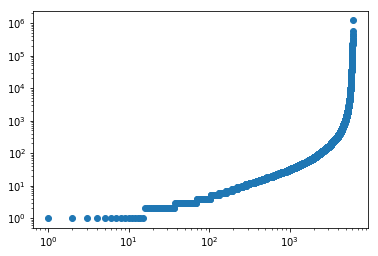

In [120]:
plt.loglog(counts_elements_summer, 'o')